# Machine Learning Analysis

We attempt to build a model which is able to predict the outcome of an NFL game based on a set of matchup statistics. We first load the data and necessary imports.

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

plt.style.use('seaborn')
pd.options.mode.chained_assignment = None

In [3]:
#Replace with proper path
path='C:\\Users\\Louie\\Repositories\\Springboard\\Capstone 1 - NFL Matchup Predictions\\Code\\Data Wrangling\\Data\\'

data = pd.read_csv(path + 'nfl_matchups.csv')

In [4]:
data.head()

,home,home_score,away,away_score,diff,home_win,week,pyds_home,ryds_home,totfd_home,...,max_yards_per_catch_away,rec_yards_max_away,rec_spread_away,max_sacks_away,max_tackles_away,sacks_away,int_take_away,forced_fumbles_away,qb_pass_to_run_away,rb_run_to_catch_away
0,PIT,13,TEN,10,3,1,1,4148,1790,331,...,16.69,701,9.91,6,93,33,20,13,0.82,0.88
1,HOU,17,TEN,20,-3,0,11,4650,1475,340,...,16.69,701,9.91,6,93,33,20,13,0.82,0.88
2,IND,27,TEN,17,10,1,13,4515,1294,339,...,16.69,701,9.91,6,93,33,20,13,0.82,0.88
3,SEA,13,TEN,17,-4,0,17,3503,1566,297,...,16.69,701,9.91,6,93,33,20,13,0.82,0.88
4,NE,59,TEN,0,59,1,6,4436,1921,373,...,16.69,701,9.91,6,93,33,20,13,0.82,0.88


### Train-Test Split
Partition the data into training and test sets. Test set will be used to evaluate the performance of our final model. Training data will be used for tuning our models. Here we also set up our predicted values and features to begin training models.

In [5]:
from sklearn.model_selection import train_test_split

X_y = data[data.columns[4:]]

train, test = train_test_split(X_y, test_size=0.2, random_state=9876)

In [6]:
train.to_csv(path + 'train.csv')
test.to_csv(path + 'test.csv')

In [7]:
y_reg = train['diff']
y_class = train['home_win']

#Bug from older code fixed here
train['rb_run_to_catch_away'] = train['rb_run_to_catch_away'].fillna(1)
train['rb_run_to_catch_home'] = train['rb_run_to_catch_home'].fillna(1)

X = train[train.columns[2:]]

### Scale
Next we normalize the data. This has benefits for almost every model and will be used throughout training. 
<br>
<br>
<br>
Main benefits include:
* Normalize coeficients of the model to allow for comparing feature importance
* Equalize influence of features on the models, applies for only some algorithms

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scale = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_scale.head()

,week,pyds_home,ryds_home,totfd_home,trnovr_home,pen_home,pass_to_run_home,completion_perc_home,pass_len_home,interceptions_turnover_home,...,max_yards_per_catch_away,rec_yards_max_away,rec_spread_away,max_sacks_away,max_tackles_away,sacks_away,int_take_away,forced_fumbles_away,qb_pass_to_run_away,rb_run_to_catch_away
0,1.584889,0.321408,-1.056513,-0.536109,0.993950,-0.774732,1.385225,-0.876136,0.770995,0.875782,...,-0.257196,-0.004693,-0.199523,0.781436,-0.108238,1.434086,0.271062,4.409165,0.396232,-0.344181
1,1.184875,0.369166,-0.114134,0.729396,-1.153548,-0.895129,-0.054300,0.816369,-0.005473,-1.354682,...,1.653283,0.587186,1.607833,-1.466575,-0.670759,0.088256,-0.367434,-0.119870,1.015272,-1.418723
2,-1.215213,-0.340618,0.693619,0.894462,-0.233191,-1.196121,-0.671239,-0.392563,0.182762,-0.543604,...,1.810571,2.400049,2.512929,-0.623571,0.243338,-0.523485,-0.793099,-0.371483,0.602579,-1.418723
3,0.184838,-0.699627,2.094948,0.206688,-1.306940,0.369036,-1.905117,1.058155,0.841582,-1.354682,...,0.084235,-1.322462,-1.091852,0.500435,2.493423,1.678782,0.483894,-0.623096,0.396232,-0.037169
4,-0.615191,0.184721,0.932273,0.729396,-1.153548,0.308838,-0.876885,0.574582,-0.146648,-0.340835,...,-0.460520,-0.369499,-0.579720,1.062438,0.313653,1.189389,0.696726,-1.126322,-0.222808,0.116337


## Linear Models

We begin by tuning a linear model on the data. We will train linear regression algorithms to estimate the difference in the points scored of the home vs away teams. When predicting new outcomes we will take the sign of the predicted and actual score difference to convert it into a classification algorithm. We will used Ridge regression to allow for regularization and tune with cross validation to find the optimal constraint value.
<br>
<br>
Below we create a custom scorer and then grid search on alpha find an optimal linear model for this feature space.

In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

def linear_regression_classifier(y_true, y_pred):
    return accuracy_score(np.sign(y_true), np.sign(y_pred))

lin_scorer = make_scorer(linear_regression_classifier, greater_is_better=True)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

parameters = {'alpha' : np.linspace(0,5,50)}

clf = GridSearchCV(Ridge(), parameters, cv=5, scoring=lin_scorer)
clf.fit(X_scale,y_reg)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.     , 0.10204, 0.20408, 0.30612, 0.40816, 0.5102 , 0.61224,
       0.71429, 0.81633, 0.91837, 1.02041, 1.12245, 1.22449, 1.32653,
       1.42857, 1.53061, 1.63265, 1.73469, 1.83673, 1.93878, 2.04082,
       2.14286, 2.2449 , 2.34694, 2.44898, 2.55102, 2.65306, 2.7551 ,...63, 4.18367,
       4.28571, 4.38776, 4.4898 , 4.59184, 4.69388, 4.79592, 4.89796,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(linear_regression_classifier), verbose=0)

In [11]:
clf.best_params_

{'alpha': 0.10204081632653061}

In [12]:
clf.best_score_

0.6887640449438203

#### Polynomial Features

Next we added interaction features to the data and retrained the model. By adding extra interraction we may be able to explain more complex patterns in the data. This would improve perfromance if the model was underfitting, however as we see the performance of the model actually decreases upon adding the new features meaning we are overfitting our model to the data (even though we are using a Ridge regression constraint!)

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_scale_2_degree = poly.fit_transform(X_scale)

In [14]:
%%time
clf.fit(X_scale_2_degree,y_reg)

Wall time: 55.5 s


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.     , 0.10204, 0.20408, 0.30612, 0.40816, 0.5102 , 0.61224,
       0.71429, 0.81633, 0.91837, 1.02041, 1.12245, 1.22449, 1.32653,
       1.42857, 1.53061, 1.63265, 1.73469, 1.83673, 1.93878, 2.04082,
       2.14286, 2.2449 , 2.34694, 2.44898, 2.55102, 2.65306, 2.7551 ,...63, 4.18367,
       4.28571, 4.38776, 4.4898 , 4.59184, 4.69388, 4.79592, 4.89796,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(linear_regression_classifier), verbose=0)

In [15]:
clf.best_params_

{'alpha': 1.836734693877551}

In [16]:
clf.best_score_

0.5837078651685393

#### Feature Selection

Understanding that our model was overfitting the data we then begin retraining the model selecting a subset of the most important features. We train our optimal Ridge Regression model (so far) and select the largest coefficients to include in the new model. The size of the absolute value of the coefficients are an indicator of importance of the feature. By selecting a subset we increase our perfromance by 1%!

In [17]:
r = Ridge(alpha=.1)
r.fit(X_scale,y_reg)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [57]:
coefs = pd.DataFrame(r.coef_, index=X_scale.columns)
coefs.columns = ['coef']
coefs['coef'] = np.abs(coefs['coef'])

<BarContainer object of 10 artists>

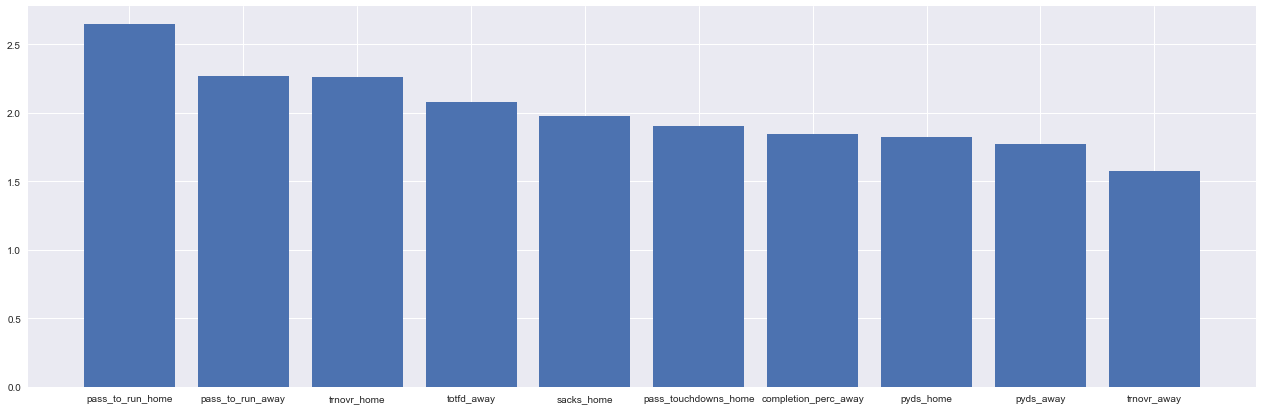

In [19]:
top = coefs.nlargest(n=10, columns='coef')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 22
fig_size[1] = 7

plt.bar(top.index, top['coef'])

In [20]:
clf.fit(X_scale[top.index],y_reg)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.     , 0.10204, 0.20408, 0.30612, 0.40816, 0.5102 , 0.61224,
       0.71429, 0.81633, 0.91837, 1.02041, 1.12245, 1.22449, 1.32653,
       1.42857, 1.53061, 1.63265, 1.73469, 1.83673, 1.93878, 2.04082,
       2.14286, 2.2449 , 2.34694, 2.44898, 2.55102, 2.65306, 2.7551 ,...63, 4.18367,
       4.28571, 4.38776, 4.4898 , 4.59184, 4.69388, 4.79592, 4.89796,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(linear_regression_classifier), verbose=0)

In [21]:
clf.best_params_

{'alpha': 0.0}

In [22]:
clf.best_score_

0.6921348314606741

Here we try using feature interaction on the limited features to see if performance increases, however again the model begins to overfit.

In [23]:
clf.fit(poly.fit_transform(X_scale[top.index]),y_reg)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.     , 0.10204, 0.20408, 0.30612, 0.40816, 0.5102 , 0.61224,
       0.71429, 0.81633, 0.91837, 1.02041, 1.12245, 1.22449, 1.32653,
       1.42857, 1.53061, 1.63265, 1.73469, 1.83673, 1.93878, 2.04082,
       2.14286, 2.2449 , 2.34694, 2.44898, 2.55102, 2.65306, 2.7551 ,...63, 4.18367,
       4.28571, 4.38776, 4.4898 , 4.59184, 4.69388, 4.79592, 4.89796,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(linear_regression_classifier), verbose=0)

In [24]:
clf.best_params_

{'alpha': 3.4693877551020407}

In [25]:
clf.best_score_

0.6803370786516854

#### Validating assumptions
The Linear Regression model is based on the assumption that given a state of the features (X) the predicted variable (Y) is normally distributed. Here we test this assumption by scattering our data vs the quantile values of a normal distribution. We see that our model is actually slightly assymetrical, overpredicting the amount of points scored by the home team and underpredicting the amount scored by the away team. Because of this if we find other models which perform at the same level we may want to consider dropping this model.

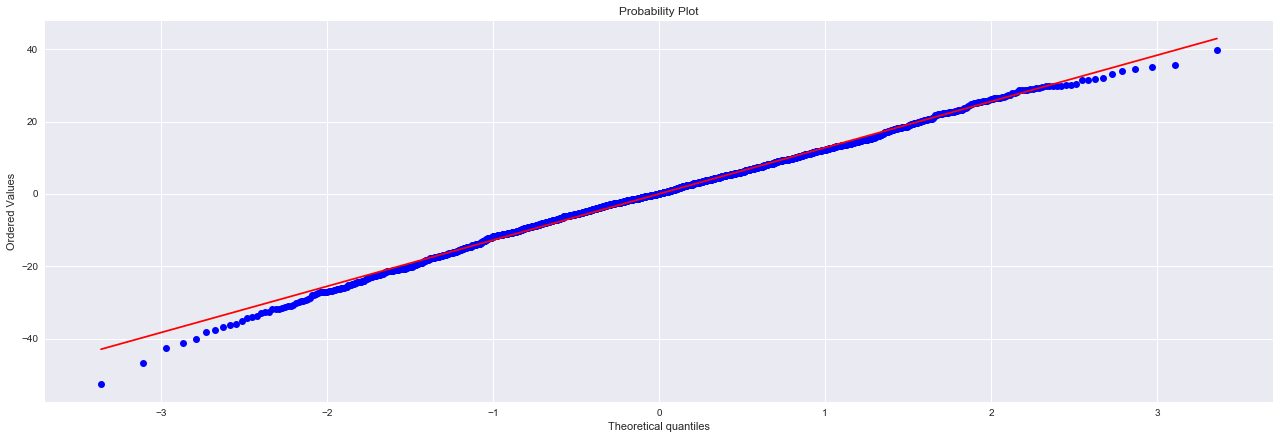

In [30]:
import pylab
stats.probplot(r_f.predict(X_scale[top.index]) - y_reg, dist="norm", plot=pylab)
pylab.show()

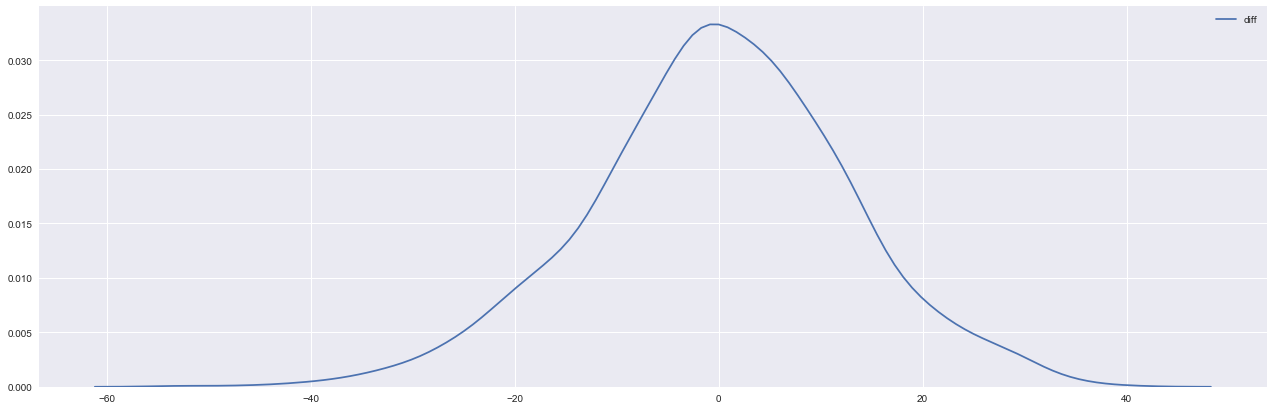

In [31]:
sns.kdeplot(r_f.predict(X_scale[top.index]) - y_reg)

## Logistic Regression

Next we train and test a Logistic Regression model in a similar pattern as was done for the Linear Regression model. We tune a regularization constant as well as search for an optimal collection of features.

Our data in this case follows the assumptions of the Logistic Model better than the Linear Model. We also see an accuracy performance improvement making it the superior model at this stage in our analysis.

In [37]:
from sklearn.linear_model import LogisticRegression

parameters = {'C' : np.linspace(0.01,5,50)}
log_clf = GridSearchCV(LogisticRegression(), parameters, cv=5)
log_clf.fit(X_scale, y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.11184, 0.21367, 0.31551, 0.41735, 0.51918, 0.62102,
       0.72286, 0.82469, 0.92653, 1.02837, 1.1302 , 1.23204, 1.33388,
       1.43571, 1.53755, 1.63939, 1.74122, 1.84306, 1.9449 , 2.04673,
       2.14857, 2.25041, 2.35224, 2.45408, 2.55592, 2.65776, 2.75959,
   ...47, 4.18531,
       4.28714, 4.38898, 4.49082, 4.59265, 4.69449, 4.79633, 4.89816,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
log_clf.best_params_

{'C': 0.01}

In [39]:
log_clf.best_score_

0.6898876404494382

Again we see that increasing the feature space causes overfitting and overall poorer model performance.

In [40]:
log_clf.fit(X_scale_2_degree, y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.11184, 0.21367, 0.31551, 0.41735, 0.51918, 0.62102,
       0.72286, 0.82469, 0.92653, 1.02837, 1.1302 , 1.23204, 1.33388,
       1.43571, 1.53755, 1.63939, 1.74122, 1.84306, 1.9449 , 2.04673,
       2.14857, 2.25041, 2.35224, 2.45408, 2.55592, 2.65776, 2.75959,
   ...47, 4.18531,
       4.28714, 4.38898, 4.49082, 4.59265, 4.69449, 4.79633, 4.89816,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
log_clf.best_params_

{'C': 0.01}

In [42]:
log_clf.best_score_

0.6297752808988764

Next trim down the feature space to the most influential variables and obtain a performance of 70% accuracy upon cross validation

In [135]:
l = LogisticRegression(C=.01)
l.fit(X_scale, y_class)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [136]:
coefs = pd.DataFrame(l.coef_[0], index=X_scale.columns)
coefs.columns = ['coef']
coefs['coef'] = np.abs(coefs['coef'])
top = coefs.nlargest(n=20, columns='coef')

In [137]:
log_clf.fit(X_scale[top.index], y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.11184, 0.21367, 0.31551, 0.41735, 0.51918, 0.62102,
       0.72286, 0.82469, 0.92653, 1.02837, 1.1302 , 1.23204, 1.33388,
       1.43571, 1.53755, 1.63939, 1.74122, 1.84306, 1.9449 , 2.04673,
       2.14857, 2.25041, 2.35224, 2.45408, 2.55592, 2.65776, 2.75959,
   ...47, 4.18531,
       4.28714, 4.38898, 4.49082, 4.59265, 4.69449, 4.79633, 4.89816,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [138]:
log_clf.best_params_

{'C': 0.01}

In [139]:
log_clf.best_score_

0.7

## Support Vector Machines

Here we investigate the SVM model and as with the previous models we tune hyperparameters using cross validation. This includes constraint constants as well as kernals. We increase the accuracy to 70.2% after limiting the features using weights from logistic regression.

In [142]:
from sklearn.svm import SVC

parameters = {'C':np.linspace(0.01,5,10), 
              'kernel':['linear','poly','rbf','sigmoid'],
              'gamma':np.linspace(.0001,.5,10)}

svm_clf = GridSearchCV(SVC(probability=True), parameters, cv=5)
svm_clf.fit(X_scale, y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.56444, 1.11889, 1.67333, 2.22778, 2.78222, 3.33667,
       3.89111, 4.44556, 5.     ]), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': array([1.00000e-04, 5.56444e-02, 1.11189e-01, 1.66733e-01, 2.22278e-01,
       2.77822e-01, 3.33367e-01, 3.88911e-01, 4.44456e-01, 5.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [143]:
svm_clf.best_params_

{'C': 3.8911111111111114, 'gamma': 0.0001, 'kernel': 'linear'}

In [144]:
svm_clf.best_score_

0.6898876404494382

In [146]:
svm_clf.fit(X_scale[top.index], y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.56444, 1.11889, 1.67333, 2.22778, 2.78222, 3.33667,
       3.89111, 4.44556, 5.     ]), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': array([1.00000e-04, 5.56444e-02, 1.11189e-01, 1.66733e-01, 2.22278e-01,
       2.77822e-01, 3.33367e-01, 3.88911e-01, 4.44456e-01, 5.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [147]:
svm_clf.best_params_

{'C': 0.01, 'gamma': 0.5, 'kernel': 'sigmoid'}

In [148]:
svm_clf.best_score_

0.702808988764045

## Random Forest

We attempt to fit a Random Forest Decision tree model to the data however the performance is significantly weaker than the previous models.

In [159]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'min_samples_split':[.6,.7,.8,.9], 
              'max_depth':[3,5,7,10],
              'max_features':[.3,.5,.7,.9]}

rf_clf = GridSearchCV(RandomForestClassifier(n_estimators=1000), parameters, cv=5)
rf_clf.fit(X_scale, y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [0.6, 0.7, 0.8, 0.9], 'max_depth': [3, 5, 7, 10], 'max_features': [0.3, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [160]:
rf_clf.best_params_

{'max_depth': 7, 'max_features': 0.9, 'min_samples_split': 0.6}

In [161]:
rf_clf.best_score_

0.6303370786516854

In [162]:
rf_clf.fit(X_scale[top.index],y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [0.6, 0.7, 0.8, 0.9], 'max_depth': [3, 5, 7, 10], 'max_features': [0.3, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [163]:
rf_clf.best_params_

{'max_depth': 7, 'max_features': 0.9, 'min_samples_split': 0.6}

In [164]:
rf_clf.best_score_

0.6325842696629214

## Feature Engineering

We select the top two models SVM and Logistic Regression and begin to experiment with some feature engineering to try and increase the performance of the models.

Let's first take a look at the features used to optimize our models.

In [165]:
top.index

Index(['trnovr_home', 'pass_to_run_away', 'int_take_home', 'sacks_home',
       'completion_perc_away', 'rush_touchdowns_home', 'pass_touchdowns_away',
       'int_take_away', 'trnovr_away', 'pass_len_away', 'pass_touchdowns_home',
       'sacks_away', 'rec_max_touchdowns_home', 'totfd_away',
       'pass_to_run_home', 'running_back_avg_away', 'completion_perc_home',
       'forced_fumbles_away', 'pen_home', 'rec_yards_max_away'],
      dtype='object')

Next we engineer some features based on our domain knowledge and features of importance

In [171]:
X['sack_chance_home'] = X['sacks_home'] * X['pass_to_run_away']
X['sack_chance_away'] = X['sacks_away'] * X['pass_to_run_home']

X['int_chance_home'] = X['int_take_home'] * X['pass_to_run_away']
X['int_chance_away'] = X['int_take_away'] * X['pass_to_run_home']

X['pass_eff_home'] = X['completion_perc_home'] * X['pass_len_home']
X['pass_eff_away'] = X['completion_perc_away'] * X['pass_len_away']

X['turn_diff_home'] =  X['int_take_home'] + X['forced_fumbles_home'] - X['trnovr_home']
X['turn_diff_away'] =  X['int_take_away'] + X['forced_fumbles_away'] - X['trnovr_away']

X['touchdowns_home'] = X['pass_touchdowns_home'] + X['rush_touchdowns_home']
X['touchdowns_away'] = X['pass_touchdowns_away'] + X['rush_touchdowns_away']

After testing out some feature combinations we are able to get a very mild performance increase with 70.3% accuracy on an SVM model

In [201]:
features = ['trnovr_home', 'pass_to_run_away', 'int_take_home', 'sacks_home',
       'completion_perc_away', 'rush_touchdowns_home', 'pass_touchdowns_away',
       'int_take_away', 'trnovr_away', 'pass_len_away', 'pass_touchdowns_home',
       'sacks_away', 'rec_max_touchdowns_home', 'totfd_away',
       'pass_to_run_home', 'running_back_avg_away', 'completion_perc_home',
       'forced_fumbles_away', 'pen_home', 'rec_yards_max_away','int_chance_home','int_chance_away']

In [202]:
X_features_scale = pd.DataFrame(scaler.fit_transform(X[features]), columns=features)
X_features_scale.head()

,trnovr_home,pass_to_run_away,int_take_home,sacks_home,completion_perc_away,rush_touchdowns_home,pass_touchdowns_away,int_take_away,trnovr_away,pass_len_away,...,rec_max_touchdowns_home,totfd_away,pass_to_run_home,running_back_avg_away,completion_perc_home,forced_fumbles_away,pen_home,rec_yards_max_away,int_chance_home,int_chance_away
0,0.993950,-0.672931,-0.170134,-0.678896,0.345107,-0.748044,0.908561,0.271062,2.680581,0.274201,...,-0.557358,0.439059,1.385225,0.290028,-0.876136,4.409165,-0.774732,-0.004693,-0.328573,0.661428
1,-1.153548,0.567473,0.464747,-0.188609,0.589552,0.967830,1.174117,-0.367434,-1.010218,-0.100325,...,-0.557358,0.576666,-0.054300,0.908766,0.816369,-0.119870,-0.895129,0.587186,0.619319,-0.366254
2,-0.233191,0.567473,-0.170134,0.669393,1.322886,-0.533560,1.041339,-0.793099,-0.548868,0.625320,...,0.435401,1.732565,-0.671239,0.639059,-0.392563,-0.371483,-1.196121,2.400049,-0.023505,-0.898447
3,-1.306940,0.360739,-0.170134,0.179106,-0.388228,0.967830,-0.286443,0.483894,-0.395085,-0.252477,...,0.435401,-0.771883,-1.905117,-0.376305,1.058155,-0.623096,0.369036,-1.322462,-0.074349,-0.105663
4,-1.153548,-0.052729,0.041493,0.914537,1.322886,1.396798,2.103565,0.696726,-1.317785,0.028418,...,-0.557358,0.714273,-0.876885,-1.407535,0.574582,-1.126322,0.308838,-0.369499,0.027340,0.397167


In [203]:
log_clf.fit(X_features_scale, y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.11184, 0.21367, 0.31551, 0.41735, 0.51918, 0.62102,
       0.72286, 0.82469, 0.92653, 1.02837, 1.1302 , 1.23204, 1.33388,
       1.43571, 1.53755, 1.63939, 1.74122, 1.84306, 1.9449 , 2.04673,
       2.14857, 2.25041, 2.35224, 2.45408, 2.55592, 2.65776, 2.75959,
   ...47, 4.18531,
       4.28714, 4.38898, 4.49082, 4.59265, 4.69449, 4.79633, 4.89816,
       5.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [204]:
log_clf.best_params_

{'C': 4.287142857142857}

In [205]:
log_clf.best_score_

0.702808988764045

In [206]:
svm_clf.fit(X_features_scale, y_class)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.56444, 1.11889, 1.67333, 2.22778, 2.78222, 3.33667,
       3.89111, 4.44556, 5.     ]), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': array([1.00000e-04, 5.56444e-02, 1.11189e-01, 1.66733e-01, 2.22278e-01,
       2.77822e-01, 3.33367e-01, 3.88911e-01, 4.44456e-01, 5.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [207]:
svm_clf.best_params_

{'C': 5.0, 'gamma': 0.0001, 'kernel': 'linear'}

In [208]:
svm_clf.best_score_

0.7033707865168539